# Compressed Sensing using Generative Models: A Study on MNIST Sensing

**Supervised By:** Dr. RIM AMARA BOUJEMAA  
**Date:** Feb 2024 - JUN 2024

## Project Overview
This project focuses on integrating generative models (such as VAEs) with compressed sensing techniques to enhance the reconstruction of MNIST digit images using fewer measurements. By leveraging the sparsity of data, compressed sensing reduces the need for excessive data sampling, while generative models improve the quality of reconstruction.

## Key Contributions
- Implemented a compressed sensing framework with generative models for image reconstruction.
- Trained GANs and VAEs to generate and reconstruct MNIST digits with minimal data.
- Evaluated the performance using metrics like:
  - Peak Signal-to-Noise Ratio (PSNR)
  - Structural Similarity Index (SSIM)
  - Mean Squared Error (MSE)

## Technologies Used
- **Programming Languages:** Python
- **Libraries/Frameworks:** TensorFlow, NumPy, SciPy, Matplotlib
- **Models:** Variational Autoencoders (VAEs)

## Results
- Achieved improved reconstruction quality over traditional compressed sensing methods.
- Demonstrated the effectiveness of generative models in recovering signals from sparse data.

## Future Work
- Investigate the application of these techniques on more complex datasets.
- Explore other generative models and reconstruction algorithms to further enhance image quality.

## Keywords
Compressed Sensing, Generative Models, MNIST, VAEs, Image Reconstruction, PSNR, SSIM, MSE


In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
np.random.seed(10500)

In [4]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [5]:
train_size = 60000
batch_size = 32
test_size = 10000

In [6]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

### Key Components and Logic

1. **Encoder**: 
    - The encoder learns to compress the input image into a lower-dimensional latent space. 
    - It uses two convolutional layers with ReLU activations to extract image features, followed by a dense layer that outputs both the mean and log variance of the latent space distribution.
    - The last layer does not apply activation since it outputs raw values needed for the latent space parameters.

2. **Latent Space (Reparameterization Trick)**:
    - VAEs generate a latent variable `z` by sampling from a distribution parameterized by the mean and log variance from the encoder.
    - This step ensures the model can backpropagate through stochastic nodes, allowing it to train via gradient-based optimization.

3. **Decoder**: 
    - The decoder aims to reconstruct the image from the latent space.
    - It starts with a dense layer that reshapes the latent vector into a 7x7x32 feature map, then applies transposed convolution layers to gradually upscale and reconstruct the original 28x28 image.
    - The final transposed convolution layer outputs an image with 1 channel (grayscale).

4. **Sampling**:
    - The `sample` function allows for generating new images by sampling from the learned latent space. This enables the model to generate new, unseen examples that resemble the original data.

5. **Encoding and Decoding**:
    - `encode` takes an input image and produces the latent space parameters (mean and log variance).
    - `decode` takes a latent vector `z` and reconstructs the image, optionally applying a sigmoid activation for pixel probabilities between 0 and 1.

6. **Reparameterize**:
    - The reparameterization trick is essential for generating differentiable samples from the latent space. It combines the learned mean and log variance with random noise to generate the latent variable `z`.


In [7]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None, n=100, decode = False):
    if eps is None:
      eps = tf.random.normal(shape=(n, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

### Optimizer and Loss function

- **Adam Optimizer** is chosen for its adaptive learning rate and momentum properties, which are ideal for training large neural networks.
- The **ELBO loss** balances the reconstruction of input images and regularization of the latent space through the KL divergence, ensuring that the latent representations conform to a standard Gaussian distribution.
```

This markdown explains the logic behind using the Adam optimizer and the loss function in the context of training a Convolutional VAE (CVAE).

In [8]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [9]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [10]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [11]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -156.5222625732422, time elapse for current epoch: 41.2792181968689


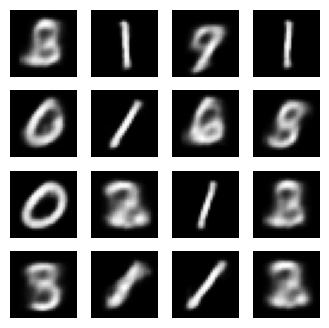

In [12]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [13]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

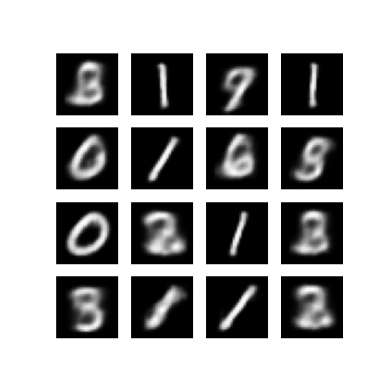

In [14]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

In [15]:
import imageio.v2 as imageio
import glob

anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


In [16]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-bpscg6co
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-bpscg6co
  Resolved https://github.com/tensorflow/docs to commit 98fa05949ba64f95c4df6565ea915a002a240289
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.7.15.51478-py3-none-any.whl size=186652 sha256=a1104c885f52388a87154931698bee6cca73a98bffb3f26be02b376619fceaa4
  Stored in directory: /tmp/pip-ephem-wheel-cache-f3l56hcx/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs



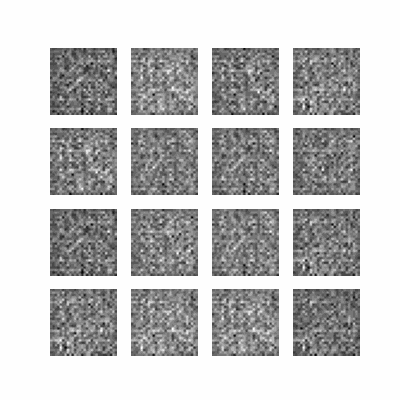

In [17]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [18]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

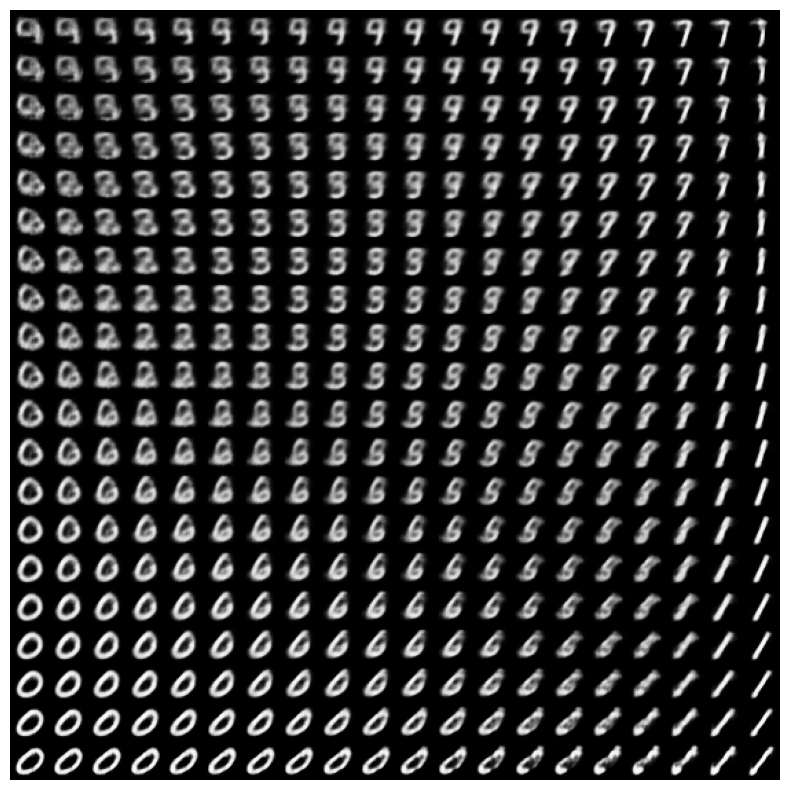

In [19]:
plot_latent_images(model, 20)

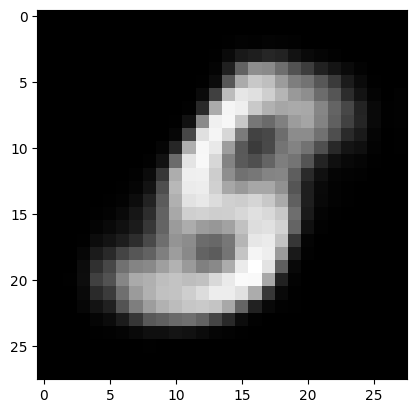

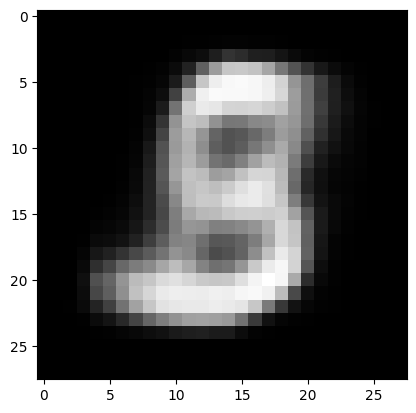

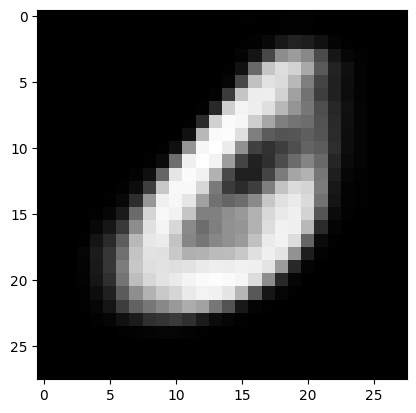

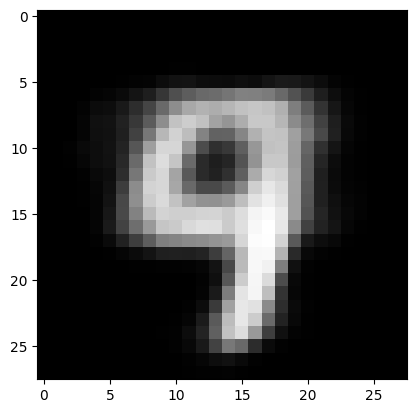

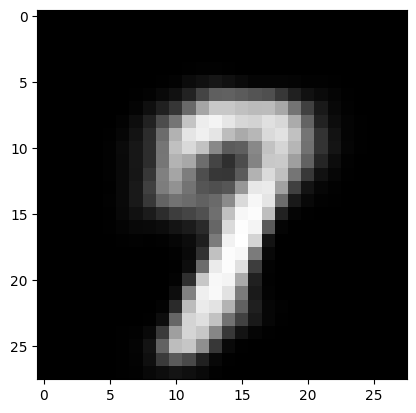

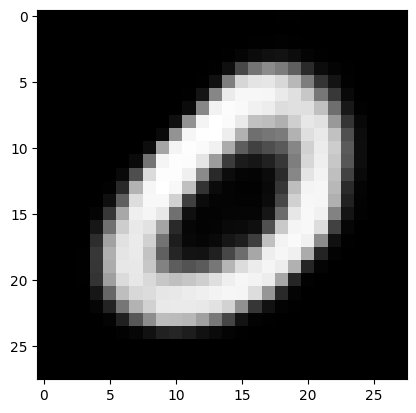

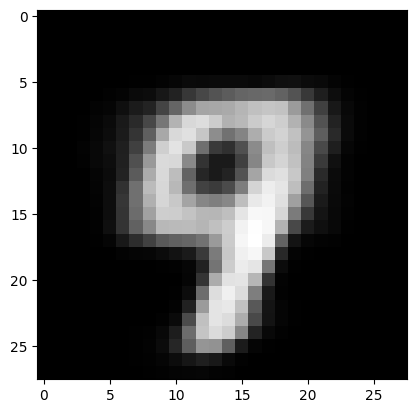

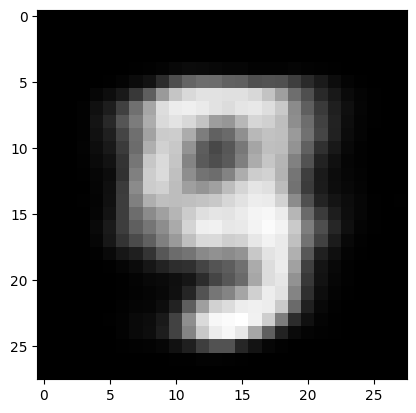

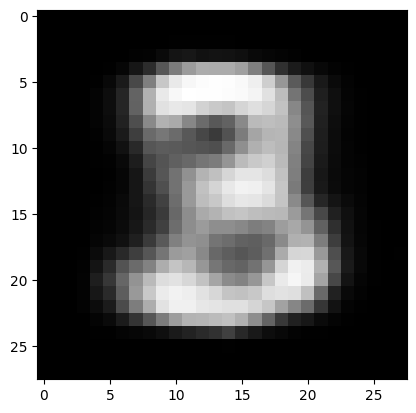

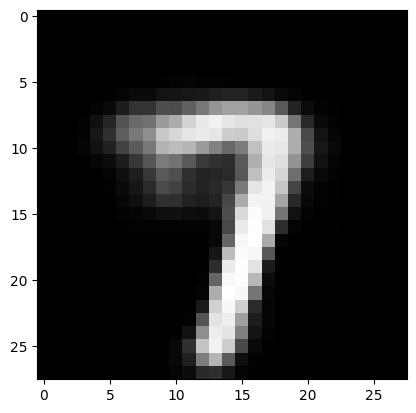

In [20]:
n = 100

eps = tf.random.normal(shape=(10, 2))
img = model.decode(eps, apply_sigmoid=True)
for i in range(10):
    plt.imshow(img[i],cmap='Greys_r')
    plt.show()

In [21]:
class Compressor:
    def __init__(self,num_measurements = 20, size=784):
        self.num_measurements=num_measurements
        self.size=size
        A_scale = 1.0 / self.num_measurements
        self.A = np.random.normal(size=[self.size, self.num_measurements], scale=A_scale).astype(np.float32)
        
    def flatten_imgs(self, img):
        return tf.reshape(img, (-1, self.size))
    
    def compress(self,img):      
        y = tf.matmul(self.flatten_imgs(img), self.A)
        return y

In [22]:
comp=Compressor()
img=train_images[1]
y=comp.compress(img)
y

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[-0.36265394, -0.13173687,  0.04627357, -0.10214198, -0.51801676,
         1.3680491 ,  0.85432947, -0.13057646, -0.05967413,  0.3363702 ,
        -0.8614489 , -0.9209017 ,  1.2019302 , -1.0807562 , -0.30136082,
         0.26784122, -0.32694045,  0.11049518, -0.16039054,  0.51051325]],
      dtype=float32)>

In [23]:
def sample(n = 1, latent_dim = 2):
    eps = tf.random.normal(shape=(n, latent_dim))
    return eps

In [24]:
def loss_fn(z, y_hat):
    
            # Generate sample from generator model
            x_hat = model.decode(z, apply_sigmoid = True)
            
            # Compute measurement error (kAG(z) - y)^2
            y_hat = comp.compress(x_hat)
            assert y_hat.shape == y.shape
            measurement_error = tf.norm(y_hat - y, ord=2)**2
            
            return measurement_error

In [25]:
# Use an optimizer to minimize the loss with respect to z
z = tf.Variable(sample(), dtype=tf.float32, trainable = True, name = "z")
learning_rate = 1e-4

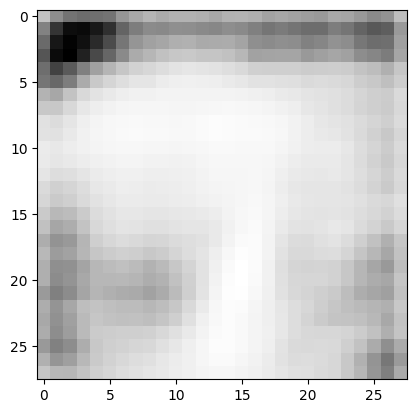

In [26]:
decoded_before = model.decode(z)[0]
plt.imshow(decoded_before, cmap='Greys_r')
plt.show()

In [27]:
for i in range(1000):  # Adjust the number of optimization steps as needed
    with tf.GradientTape() as tape:
        loss = loss_fn(z, img)
                
        gradients = tape.gradient(loss, z)
        z.assign_sub(gradients*learning_rate)
        
    print(gradients)  
        
# After optimization, use the optimal z to generate the reconstructed x_hat

tf.Tensor([[-0.4146526   0.45161077]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.41460705  0.45160893]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.41456103  0.45160696]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.41451466  0.4516046 ]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.41446865  0.45160207]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.41157597  0.4522562 ]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.4115317   0.45225352]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.41148698  0.45225084]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.4113536   0.45114738]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.4112835   0.45124483]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.41123843  0.45124266]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.41119474  0.45124027]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.4111498  0.4512382]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.41110528  0.45123577]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.4110607   0.45123363]], shape=(1, 2

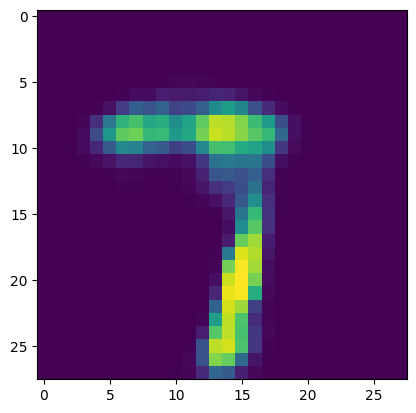

In [28]:
plt.imshow(model.decode(z, apply_sigmoid = True)[0])
plt.show()

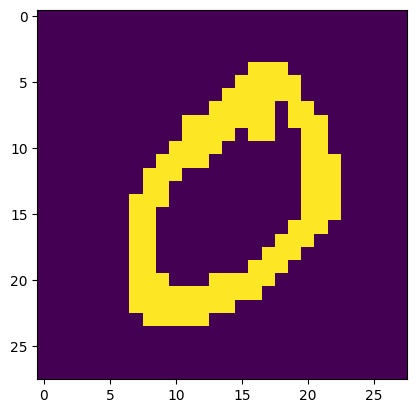

In [29]:
plt.imshow(tf.reshape(img, (28,28)))
plt.show()